# Neural Net Classification
This neural net is very similar to the neural net I built for regression (see notebook in repository), but has different descent formulas because of the use of the softmax function in the final layer. The softmax function transforms the T layer output into a class probability. 
The following functions define the layers of the neural net:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as mt


##sigmoid function
def sigmoid(eta):
    if eta>1e2:
        return 1.0
    if eta <-1e2:
        return 0.0
    else:
        return 1/(1+mt.exp(-eta))

##derivative is just s*(1-s). nice
def sigmoid_grad(eta):
    return sigmoid(eta)*(1-sigmoid(eta))

##dot product function
def dot(a,b):
    tot = 0
    for i in range(len(a)):
        tot = tot+(a[i]*b[i])
        
    return(tot) 

##this just returns index of your highest item
def argmax(f):
    return f.index(max(f))
##Create NN 

#function that computes Z_mis.
##essentially what we are doing is transforming our data to put into a regression model
##but that transformation is fit to the data!
def Zfunc(alpha,x,M):
    
    ##eta stores the arguments for sigmoid function in length M vectors for data point i
    eta = [[] for i in range(len(x))]
    ##this fills in the eta vector
    for i in range(len(x)):
        eta[i] = [alpha[m][0]+dot(alpha[m][1:],x[i]) for m in range(M)]
    
    ##calculates z using eta and sigmoid. stores in length M vectors for data point i
    z = [[sigmoid(eta[i][m]) for m in range(M)] for i in range(len(x))]
    #print(z[0][0])
    return z
##test Z: print(Zfunc([[1,1,1],[0,0,0]],[[1,1]],2))

##function that computes T_kis. This step is linear
def Tfunc(beta,z,K):
    T = [[] for i in range(len(z))]
    #cycles through class j of k and creates T_ks for each data i in z
    for i in range(len(z)):
        T[i] = [beta[k][0]+dot(beta[k][1:],z[i]) for k in range(K)]
    
    return T
##test T: print(Tfunc([[0,1,1]],[[.5,.5]],1))
##function that normalizes T - would only use for classification
##returns k-length vector to be used in f function with values in {0-1}. 
#Max argument of vector is class    
def softmax(K,T):
    if K ==0:
        K = 1
    tot =0
    for k in range(K):
        tot = tot + mt.exp(T[k])
    g = [mt.exp(T[k])/tot for k in range(K)]
    return g
##test softmax print(softmax(2,[.5,.5]))

##the gradient is pretty convinient actually...
def softmax_grad(K,T):
    g = softmax(K,T)
    return [g[i]*(1- g[i]) for i in range(len(g))]

##function that computes f_kis. will output n length vector of k-length vectors
##with values between 0 and 1.
##the max value of each k-length vector is the class
def Ffunc(T,K):
    f = [[] for i in range(len(T))]
    for i in range(len(T)):
        f[i] = softmax(K,T[i])
        
    return f
#Test Ffunc: print(Ffunc([[.5,.5]],2))

# Back-Propagation
The back-propagation functions differ from the regression versions in their steepest descent formulas due to the use of the softmax function.

In [2]:
##function that computes error - use sum of squared errors
def Rfunc(y,f):
    error = 0
    for i in range(len(y)):
        for k in range(len(y[0])):
            error = error + (y[i][k]-f[i][k])**2
    return error
#test Rfunc: print(Rfunc([[0,1]],[[1,0]]))
    
##add penalty to error - remember to use weight decay lambda...
#dont actually use this anywhere just for kicks
def Jfunc(R, alpha, beta):
    beta_sum = 0
    alpha_sum = 0
    
    for k in range(len(beta)):
        for m in range(len(beta[0])):
            beta_sum = beta_sum + beta[m]**2
            
    for m in range(len(alpha)):
        for l in range(len(alpha[0])):
            alpha_sum = alpha_sum + alpha[l]**2
    
    return alpha_sum + beta_sum

##gradient functions for steepest descent
##gradient with respect to beta
def beta_grad(beta,y,x,M,K,f,z,T,lam):
    ##store as vector of vector of vector of ms in ks in is
    grad = [[np.zeros(M+1) for k in range(K)] for i in range(len(x))]
    ##fill er up
    for i in range(len(x)): ##each data point
        for k in range(K): ##each class
            for m in range(1,M+1): ##each unit
                grad[i][k][m] = -2*(y[i][k]-f[i][k])*softmax_grad(K,T[i])[k]*z[i][m-1]#+2*lam*beta[k][m]
    ##the penalty function is causing issues! remove it we dont need you
    #print (grad[4][0])            
    return grad

##gradient with respect to alpha
def alpha_grad(alpha,beta,y,x,M,K,f,z,T,lam):
    ##store as vector of vector of ls in ms in is
    L = len(alpha[0])
    grad = [[np.zeros(L) for i in range(M)] for j in range(len(x))]
    ##fill er up
    Ktot  = 0
    for i in range(len(x)): ##each data point
        for m in range(1,M): ##each unit
            for l in range(1,L): ##each alpha
                Ktot = 0
                for k in range(K):
                    Ktot = Ktot + 2*(y[i][k] - f[i][k])*-1*softmax_grad(K,T[i])[k]*beta[k][m]*sigmoid_grad(dot(alpha[m][1:],x[i]))*x[i][l-1]#+2*lam*alpha[m][l]
                grad[i][m][l] = -Ktot
    ##remove penalty
    #print(grad[4][1])
    return grad


##steepest descent - leave out the penalty for now 
def beta_descent(beta,x,K,M,grad,gamma):
    for k in range(K): ##each class
        for m in range(1,M+1): ##each unit
            tot = 0
            for i in range(len(x)): ##each data point 
                tot = tot + grad[i][k][m]
            #print(tot)
            beta[k][m] = beta[k][m] - gamma*tot 
    return(beta)
#Test: print(beta_descent([[1,1,1]],[[0]],1,2,[[[0,2,2]]],1))

def alpha_descent(alpha,x,M,grad,gamma):
    L = len(alpha[0])
    for m in range(0,M):
        for l in range(0,L):
            tot = 0 
            for i in range(len(x)):##cylces through all data points
                tot = tot + grad[i][m][l]
                
            alpha[m][l] = alpha[m][l]  - gamma*tot
    return(alpha)
    
##test: print(alpha_descent([[1,1,1]],[[0]],1,[[[0,2,2]]],1))
##back-propagation. Takes data and weights as inputs and returns alpha and beta and f
def back_prop(x,y,M,K,alpha,beta,gamma,lam):
    Z = Zfunc(alpha,x, M)
    T = Tfunc(beta,Z,K)
    f = Ffunc(T,K)
    
    a_grad = alpha_grad(alpha,beta,y,x,M,K,f,Z,T,lam) 
    b_grad = beta_grad(beta,y,x,M,K,f,Z,T,lam)
    
    #print(a_grad[1][1])
    
    alpha = alpha_descent(alpha,x,M,a_grad,gamma)
    beta = beta_descent(beta,x,K,M,b_grad,gamma)
    
    return [alpha,beta,f]


##create random alphas and betas around 0
def NNC(x,y,K,M,lam):
    gamma =.5##learning rate- for some reason if this guy is not small we get huge and ascend #5e-1 is stable
    L = len(x[0]) 
    ##initialize alpha and beta and z and t and f. Make in range of X
    alpha = (np.random.rand(M,L+1)-.5)
    beta = (np.random.rand(K,M+1)-.5)
    ##start with looping a couple times
    for i in range(2000):
        theta = back_prop(x,y,M,K,alpha,beta,gamma,lam)
        alpha =theta[0]
        #print(alpha[0])
        beta =theta[1]
        #print(beta[1])
        err  = Rfunc(y,theta[2])
        #if i%10 ==0:
         #   print(err)
        
    return [err,theta]



## Visualize results for Iris Data 
I import the Iris dataset and use two inputs (petal width and length) to predict type of Iris: setosa, virgnica, or versicolor.

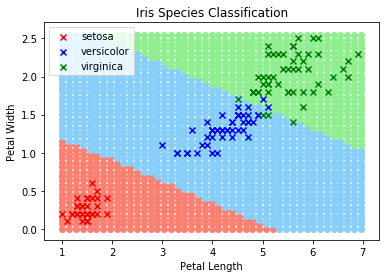

In [3]:
import pandas as pd
iris = pd.read_excel(r'C:/Users/Will/Desktop/Projects/Iris.xlsx')
iris = pd.DataFrame(iris)
X1 = np.asarray(iris['petal_length'])
X1norm = sum(X1)
X1 = X1/X1norm
X2 = np.asarray(iris['petal_width'])
X2norm= sum(X2)
X2=X2/X2norm
Y0 = np.asarray(iris['Y'])

##reformat x into a vector of [X1,X2] pairs and y into length 3 vector with
##class 1 = setosa, class 2 = versicolor class 3 = virginica
X = [[X1[i],X2[i]] for i in range(len(X1))]
Y = [[] for i in range(len(Y0))]
for i in range(len(Y0)):
    if Y0[i]==0:
        Y[i] = [1,0,0]
    elif Y0[i]==1:
        Y[i]=[0,1,0]
    else:
        Y[i]=[0,0,1]
M=2
K=3
result = (NNC(X,Y,K,M,10))
##function outputs vector that looks like y with classes -need to generalize
def classifyIris(f):
    out = [[] for i in range(len(f))]
    for i in range(len(f)):
        cls = argmax(f[i])
        if cls ==0:
            out[i] = [1,0,0]
        elif cls ==1:
            out[i]=[0,1,0]
        else:
            out[i]=[0,0,1]
    return out
            
predict = classifyIris(result[1][2])
percent = 0.
for i in range(len(predict)):
    if predict[i]==Y[i]:
        percent = percent + 1

percent = percent/len(predict)

#X1 = np.asarray(iris['petal_length'])
#X2 = np.asarray(iris['petal_width'])
#X = [[X1[i],X2[i]] for i in range(len(X1))]
#
#for i in range(len(predict)):
#    if predict[i]==[1,0,0]:
#        plt.scatter(X[i][0],X[i][1],color='salmon')
#    elif predict[i]==[0,1,0]:
#        plt.scatter(X[i][0],X[i][1],color='lightskyblue')
#    else:
#        plt.scatter(X[i][0],X[i][1],color='lightgreen')
##now lets do some plots

##you gotta bring this data down to the same size to test
X1Test = np.arange(1,7.1,6.1/45.)/X1norm
X2Test = np.arange(0,2.6,2.6/45.)/X2norm
X1M, X2M = np.meshgrid(X1Test,X2Test)
XTest = [[] for i in range(len(X1M))]
for i in range(len(X1M)):
    XTest[i] = [ [X1M[i][j],X2M[i][j]] for j in range(len(X1M))]
    

def Test(X,theta,K,M):
    alpha =theta[0]
    beta = theta[1]
    Z = Zfunc(alpha,X, M)
    T = Tfunc(beta,Z,K)
    f = Ffunc(T,K)
    
    #print err
    return f


            
test = [Test(XTest[i],result[1],K,M) for i in range(len(XTest))]
testpredict =[classifyIris(test[i]) for i in range(len(test))]
##now bring the data back around to what u want
X1Test = np.arange(1,7.1,6.1/45.)
X2Test = np.arange(0,2.6,2.6/45.) 
X1M, X2M = np.meshgrid(X1Test,X2Test)
##orgnize into data pairs
for i in range(len(X1M)):
    XTest[i] = [[X1M[i][j],X2M[i][j]] for j in range(len(X1M))]
for i in range(len(XTest)):
    for j in range(len(XTest[0])):
        if testpredict[i][j]==[1,0,0]:
            plt.scatter(XTest[i][j][0],XTest[i][j][1],color='salmon')
        elif testpredict[i][j]==[0,1,0]:
            plt.scatter(XTest[i][j][0],XTest[i][j][1],color='lightskyblue')
        else:
            plt.scatter(XTest[i][j][0],XTest[i][j][1],color='lightgreen')

plt.scatter((iris[iris.Y==0]['petal_length']),(iris[iris.Y==0]['petal_width']),color='red',marker='x',label = 'setosa')
plt.scatter((iris[iris.Y==1]['petal_length']),(iris[iris.Y==1]['petal_width']),color='blue',marker='x',label = 'versicolor')
plt.scatter((iris[iris.Y==2]['petal_length']),(iris[iris.Y==2]['petal_width']),color='green',marker='x', label = 'virginica')
plt.xlabel("Petal Length")
plt.ylabel("Petal Width")
plt.title("Iris Species Classification")
plt.legend()


# Conclusions
The purpose of this project was to turn math from the page into usuable code. The neural net demonstrates the ability to correctly classify the Iris data with 95% accuracy. 